### Experiment Code Ran

In [ ]:
import numpy as np
import time
from datetime import datetime, timedelta
from neuroplatform import StimShape, StimParam , IntanSofware, Trigger, Database, StimPolarity, Experiment
 
token = "9T5KLS6T7X" # We provide you a token for the experiment
exp = Experiment(token)
print(f'Electrodes: {exp.electrodes}') # Electrodes that you can used

num_elecs = 8 # 8 electrodes per NS, do the experiment in parallel on the 4 NS
 
stim_params = []
for i,elec in enumerate(exp.electrodes):
    stim_param = StimParam()
    stim_param.index = elec
    stim_param.trigger_key = i%8
    stim_param.trigger_delay = 0
    stim_param.stim_shape = StimShape.Biphasic
    stim_param.polarity = StimPolarity.PositiveFirst
    stim_param.phase_duration1 = 200.0
    stim_param.phase_duration2 = 200.0
    stim_param.phase_amplitude1 = 8.0 # 
    stim_param.phase_amplitude2 = 8.0 # 
    stim_param.enable_amp_settle = True
    stim_param.pre_stim_amp_settle = 0.0
    stim_param.post_stim_amp_settle = 1000.0
    stim_param.enable_charge_recovery = True
    stim_param.post_charge_recovery_on = 0.0
    stim_param.post_charge_recovery_off = 100.0
    stim_param.interphase_delay = 0.0
 
    stim_params.append(stim_param)
    
intan = IntanSofware()
trigger_gen = Trigger()

raw_channels = np.array(exp.electrodes, dtype=np.int32) # Did this make it only record from elec0?

try:
    if exp.start(): # Signal the start of an experiment to all users
        # Measure impedance
        intan.impedance()
 
        # Send stim parameter
        intan.send_stimparam(stim_params)

        # Start raw recording on channels selected
        intan.start_raw_recording(raw_channels)
 
        trigger0 = np.zeros(16, dtype=np.uint8)
       
        for i in range(num_elecs):
            trigger0[i] = 1
            time.sleep(300) # Sleep 300s before stim
            for j in range(40):
                trigger_gen.send(trigger0)
                time.sleep(5)
            time.sleep(300) # Sleep 300s after sending stim
            trigger0[i]=0
        
        intan.stop_raw_recording()
 
        # Disable all stims
        for stim in stim_params:
            stim.enable = False
        intan.send_stimparam(stim_params)
 
finally:
    # Close the connection to trigger generator
    trigger_gen.close()
    # Close the connection to intan software
    intan.close()
    # Signal the end of an experiment to all users
    exp.stop()


### Generate Stim Data used in Experiment

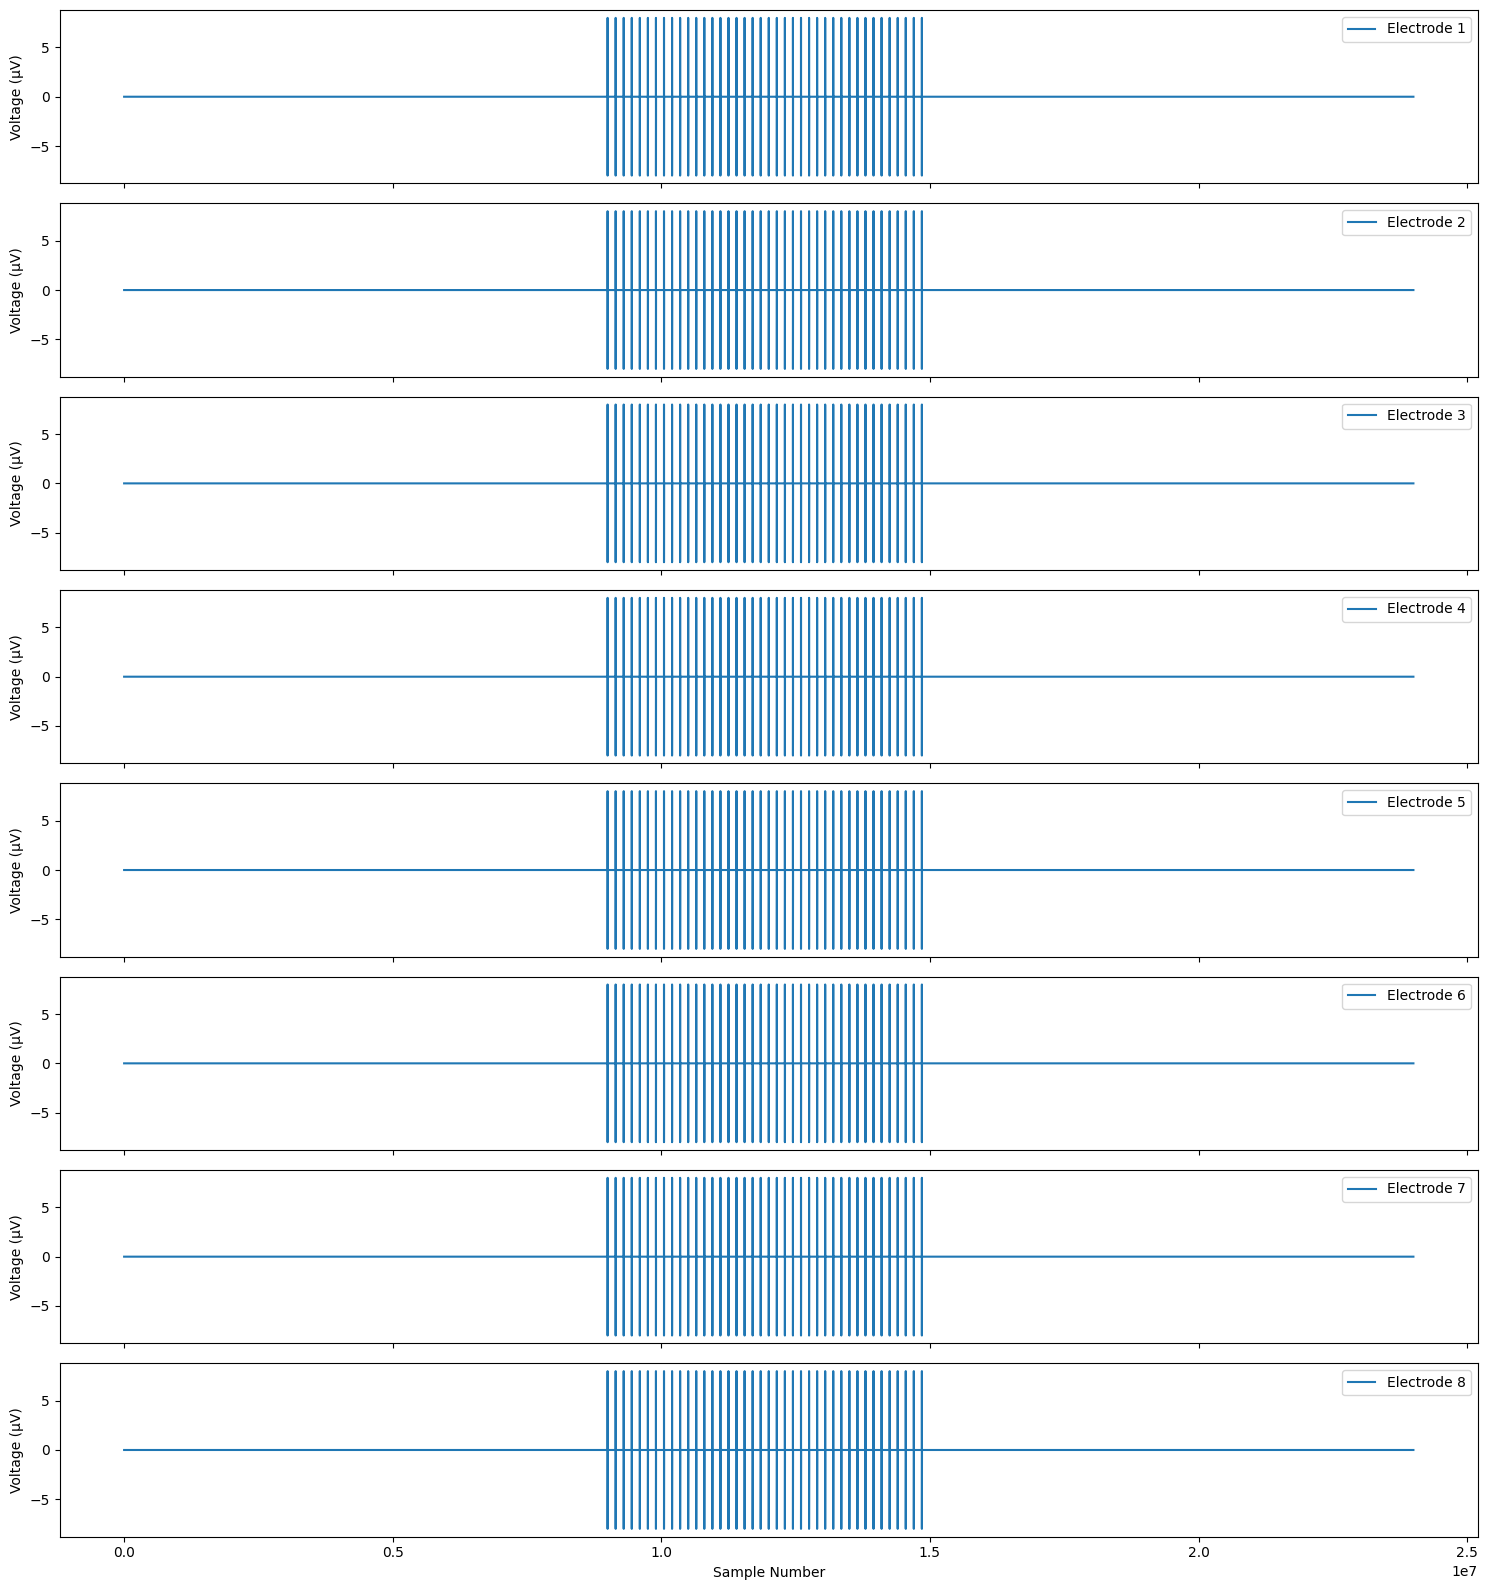

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define the stimulation parameters
phase_duration_microsec = 200.0  # duration of one phase in microseconds
amplitude_microV = 8.0  # amplitude in microvolts
sampling_rate = 30000  # sampling rate in Hz

# Convert phase_duration from microseconds to samples
phase_duration_samples = int((phase_duration_microsec * 1e-6) * sampling_rate)

# Generate the biphasic pulse
biphasic_pulse = np.concatenate([
    np.ones(phase_duration_samples) * amplitude_microV,  # positive phase
    -np.ones(phase_duration_samples) * amplitude_microV  # negative phase
])

# Calculate the total number of samples for pre-stimulation delay, stimulation, and post-stimulation delay
pre_stim_delay_samples = 300 * sampling_rate  # pre-stimulation delay of 300 seconds in samples
post_stim_delay_samples = 300 * sampling_rate  # post-stimulation delay of 300 seconds in samples
pulse_interval_samples = 5 * sampling_rate  # 5 seconds between pulses in samples
num_pulses = 40
num_elecs = 8

# Set up the figure for plotting
fig, axes = plt.subplots(num_elecs, 1, figsize=(15, 2 * num_elecs), sharex=True)

# Create and plot the stimulation sequence for each electrode
for elec in range(num_elecs):
    # Initialize the array for the entire sequence for one electrode
    total_length = pre_stim_delay_samples + num_pulses * (phase_duration_samples * 2 + pulse_interval_samples) + post_stim_delay_samples
    stimulation_sequence = np.zeros(total_length)

    # Populate the stimulation sequence
    index = pre_stim_delay_samples
    for _ in range(num_pulses):
        stimulation_sequence[index:index + phase_duration_samples * 2] = biphasic_pulse
        index += phase_duration_samples * 2 + pulse_interval_samples
    
    # Plot the sequence for the current electrode
    axes[elec].plot(stimulation_sequence, label=f'Electrode {elec+1}')
    axes[elec].legend(loc="upper right")
    axes[elec].set_ylabel('Voltage (μV)')

# Set common labels
axes[-1].set_xlabel('Sample Number')
plt.tight_layout()
plt.show()